# **Progetto SegnIA**

Il progetto si propone di sviluppare un sistema di riconoscimento del linguaggio dei segni utilizzando tecniche di computer vision e intelligenza artificiale. 

L'obiettivo principale è creare un'applicazione capace di interpretare e tradurre automaticamente i segni eseguiti con le mani in testi, facilitando così la comunicazione tra le persone sorde e chi non conosce il linguaggio dei segni. 

Il sistema sfrutta reti neurali convoluzionali (CNN) per l'analisi delle immagini, identificando i gesti e associandoli alle corrispondenti parole o frasi. Questo approccio può essere integrato in dispositivi mobili o applicazioni web, rendendo il riconoscimento accessibile in vari contesti della vita quotidiana.

## **Librerie**

- `pandas` : manipolazione e analisi del dataset

- `matplotlib`: 
    - `pyplot`: visualizzare dati e risultati dei modelli

- `numpy`: gestione di vettori, matrici e array multidimensionali

- `seaborn`: creazione di grafici statistici

- `scikit-learn` : 
    - `preprocessing` - `LabelBinarizer` : conversione delle etichette in array binario
    - `model_selection` - `train_test_split` : divisione del dataset in train e test set
    - `metrics` - `confusion_matrix` :  matrice di confusione

- `keras` : 
    - `models`-`Sequential`: costruzione di una rete neurale in modo lineare
    - `layers`:
        - `Conv2D`: convoluzione bidimensionale
        - `MaxPooling2D`: pooling
        - `Flatten`: appiattimento dell'input in un vettore unidimensionale
        - `Dense`: strato completamente connesso
        - `Dropout`:  disattivazione casuale una frazione di neuroni durante l'addestramento

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.api.regularizers import l2
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## **Dataset**

Link dataset: https://www.kaggle.com/datasets/datamunge/sign-language-mnist

Il dataset MNIST (Modified National Institute of Standards and Technology) è un ampio e noto database di immagini di cifre scritte a mano, comunemente utilizzato come benchmark nel campo dell'apprendimento automatico e della visione artificiale. Per stimolare ulteriori sviluppi, è stato creato il Sign Language MNIST, che segue lo stesso formato CSV del MNIST, ma rappresenta lettere dell'alfabeto della lingua dei segni americana (ASL) invece delle cifre.

Il dataset contiene 24 classi (lettere dell’alfabeto, escludendo J e Z che richiedono movimenti) ed è organizzato in maniera simile al MNIST, con immagini 28x28 pixel in scala di grigi e valori tra 0-255.

Il train set originale ha 27.455 immagini e quello di test 7.172, ma per garantire una migliore randomizzazione delle classi nel nostro dataset, abbiamo adottato una strategia di concatenazione e successiva suddivisione dei dati, questo contribuisce a una migliore valutazione delle performance del modello, poiché i dati di test riflettono più accuratamente la varietà presente nell'intero dataset.

In [3]:
train_df = pd.read_csv('sign_mnist_train/sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test/sign_mnist_test.csv')

df=pd.concat(([train_df, test_df]))

label = df['label']
df = df.drop(['label'], axis=1)

In [4]:
df.shape

(34627, 784)

In [5]:
label.value_counts()

label
0     1457
4     1455
2     1454
5     1451
8     1450
11    1450
24    1450
7     1449
12    1449
18    1445
10    1445
16    1443
14    1442
1     1442
13    1442
3     1441
6     1438
17    1438
15    1435
19    1434
23    1431
22    1431
21    1428
20    1427
Name: count, dtype: int64

In [28]:
sample_images = df.head(5)
sample_labels = label.head(5)

plt.figure(figsize=(10, 10))

lettere = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J" "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y"]

for i in range(10,15):
    plt.subplot(1, 5, i-10 + 1)
    image = sample_images.iloc[i].values.reshape(28, 28) 
    plt.imshow(image, cmap='gray') 
    plt.title(f'Label: {lettere[sample_labels.iloc[i]]}')  
    plt.axis('off')  

plt.tight_layout()
plt.show()

ValueError: num must be an integer with 1 <= num <= 5, not 11

<Figure size 1000x1000 with 0 Axes>

## **Preparazione dei Dati**

Il preprocessamento dei dati inizia con la normalizzazione delle immagini. La variabile X viene ottenuta convertendo i valori del dataframe df in un array di tipo float e scalando i pixel nell'intervallo [0, 1] dividendo per 255. 

Successivamente, l'array X viene rimodellato in una forma compatibile con l'input di un modello di rete neurale, specificamente in una forma di 28x28 pixel con un canale (28, 28, 1), che è comune per le immagini in bianco e nero.

In [7]:
X = df.values.astype('float') / 255
X = X.reshape(-1, 28, 28, 1)

La variabile target y è creata utilizzando `LabelBinarizer`, che trasforma le etichette categoriche in un formato binario (one-hot encoding). Questo passaggio è fondamentale per l'addestramento dei modelli di apprendimento automatico, in quanto permette di rappresentare ogni classe in modo appropriato, facilitando l'ottimizzazione durante il processo di apprendimento.

In [8]:
lb = LabelBinarizer()
y = lb.fit_transform(label)

### **Split dei Dati**
Il dataset è suddiviso in
- 20% test set
- 80% train set

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [10]:
datagen = ImageDataGenerator(
    rotation_range=10,       # Rotazione casuale fino a 15 gradi
    width_shift_range=0.1,   # Traslazione orizzontale
    height_shift_range=0.1,  # Traslazione verticale
    shear_range=0.0,         # Distorsione (shear)
    zoom_range=0.1,          # Zoom
    horizontal_flip=False,    # Capovolgimento orizzontale
    fill_mode='nearest'      # Riempimento dei pixel vuoti
)

In [11]:
datagen.fit(X_train)

## **Modello**

- **Tipo di modello**: modello sequenziale (`Sequential`), costruisce la rete neurale layer per layer in modo lineare.

- **Struttura del modello**:

    - *Layer Convoluzionali*: I layer convoluzionali (`Conv2D`) applicano un filtro (o kernel) per estrarre caratteristiche importanti dall’immagine di input. Utilizza la funzione di attivazione *ReLU*, che aiuta a introdurre non linearità nel modello.

    - *Pooling*: il pooling (`MaxPooling2D`) serve per ridurre ulteriormente la dimensione delle caratteristiche e mantenere solo le informazioni più importanti.

    - *Layer Densi*: I dati vengono "appiattiti" (`Flatten`) e passati a uno o più layer densi (`Dense`). Qui, il modello combina le informazioni apprese e le trasforma in output finali.

    - *Dropout*: Il layer di dropout (`Dropout`) serve a prevenire l’overfitting escludendo alcuni neuroni dal processo di addestramento.

- **Compilazione del modello**: Il modello viene compilato specificando l'ottimizzatore (Adam), la funzione di perdita (categorical crossentropy) e la metrica da monitorare (accuratezza). Questo permette al modello di apprendere dai dati in modo efficace.

In [12]:
model = Sequential()

num_k = [32, 64]
k_size = [3, 3]
p_size = [2, 2]
num_n = 128
# Aggiungi i layer convoluzionali e di pooling
for i in range(len(num_k)):
    if i == 0:
        model.add(Conv2D(num_k[i], (k_size[i], k_size[i]), activation='relu', input_shape=(28, 28, 1), kernel_regularizer=l2(0.01)))
    else:
        model.add(Conv2D(num_k[i], (k_size[i], k_size[i]), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D(pool_size=(p_size[i], p_size[i])))

# Aggiungi i layer densi
model.add(Flatten())
model.add(Dense(num_n, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(24, activation='softmax'))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\perri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## **Training**
Addestriamo il train set sulle etichette corrispondenti. Il modello passerà attraverso l'intero set di dati 10 volte durante l'addestramento in gruppi di 32 campioni alla volta. Viene utilizzato il 20% dei dati per la validazione, così da poter valutare le prestazioni del modello su dati non utilizzati per l'addestramento.

In [13]:
batch_size = 32  # Modifica questo valore se hai pochi dati
steps_per_epoch = len(X_train) // batch_size

# Assicurati che il generatore possa ripetere i dati
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

# Addestrare il modello
hist = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=(X_val, y_val)
)

Epoch 1/10
  1/692 ━━━━━━━━━━━━━━━━━━━━ 19:57 2s/step - accuracy: 0.0625 - loss: 3.6101

C:\Users\perri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


692/692 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.2379 - loss: 2.7067 - val_accuracy: 0.8029 - val_loss: 0.8935
Epoch 2/10
  1/692 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5938 - loss: 1.2795

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


692/692 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - accuracy: 0.5938 - loss: 1.2795 - val_accuracy: 0.8092 - val_loss: 0.8900
Epoch 3/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6671 - loss: 1.2505 - val_accuracy: 0.8991 - val_loss: 0.5683
Epoch 4/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.6562 - loss: 1.3105 - val_accuracy: 0.8993 - val_loss: 0.5642
Epoch 5/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7651 - loss: 0.9148 - val_accuracy: 0.9430 - val_loss: 0.4266
Epoch 6/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step - accuracy: 0.8125 - loss: 0.7109 - val_accuracy: 0.9478 - val_loss: 0.4248
Epoch 7/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8317 - loss: 0.7268 - val_accuracy: 0.9643 - val_loss: 0.3519
Epoch 8/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - accuracy: 0.9375 - loss: 0.6467 - val_accuracy: 0.9634 - val_loss: 0.3554
Epoch 9/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8553 - loss: 0.6579 - val_accuracy: 0

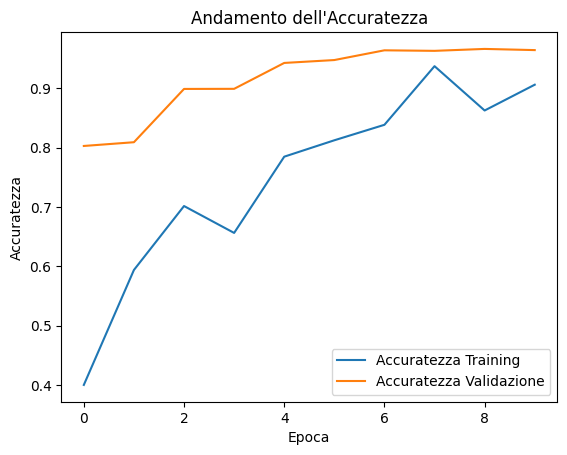

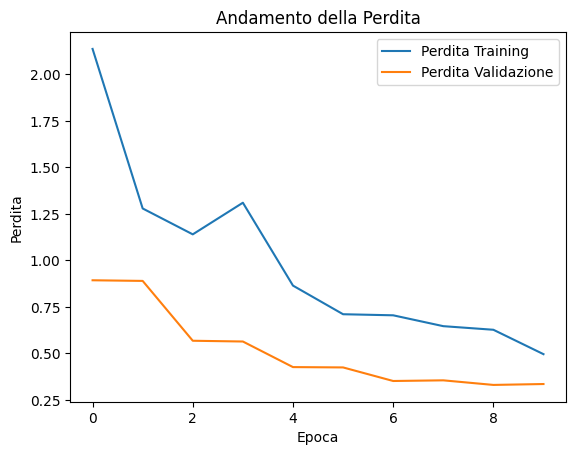

In [14]:
#Grafico Accuratezza
plt.plot(hist.history['accuracy'], label='Accuratezza Training')
plt.plot(hist.history['val_accuracy'], label='Accuratezza Validazione')
plt.xlabel('Epoca')
plt.ylabel('Accuratezza')
plt.legend()
plt.title('Andamento dell\'Accuratezza')
plt.show()

#Grafico Perdita
plt.plot(hist.history['loss'],label='Perdita Training')
plt.plot(hist.history['val_loss'], label='Perdita Validazione')
plt.xlabel('Epoca')
plt.ylabel('Perdita')
plt.legend()
plt.title('Andamento della Perdita')
plt.show()

## **Testing**
Valutiamo il modello sul test set calcolando la loss e l'accuracy.

In [15]:
# Valutazione del modello
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Perdita sul test set: {test_loss:.4f}')
print(f'Accuratezza sul test set: {test_accuracy:.4f}')


  1/217 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 1.0000 - loss: 0.2245

217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9583 - loss: 0.3467
Perdita sul test set: 0.3474
Accuratezza sul test set: 0.9589


Si calcolano le previsioni e le classi predette per ciascun campione.

In [16]:
def predictions(model, X_test):
    predictions = model.predict(X_test)
    return np.argmax(predictions, axis=1)

In [17]:
# Predizioni
predicted_classes = predictions(model, X_test)
true_classes = np.argmax(y_test, axis=1)

217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


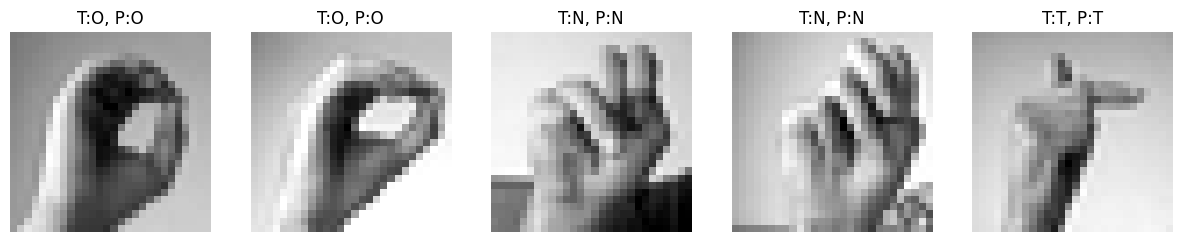

In [18]:
lettere = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y"]
num_images = 5

# Cambiare il nome della variabile 'list' per evitare conflitti
plt.figure(figsize=(15, 3))

for i in range(num_images):
    image = X_test[i].reshape(28, 28)  # Assicurati che X_test abbia immagini delle dimensioni corrette

    true_label = true_classes[i]
    true_lettera = lettere[true_label] 

    predicted_label = predicted_classes[i]
    predicted_lettera = lettere[predicted_label] 
    
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(f'T:{true_lettera}, P:{predicted_lettera}')

plt.show()


### **Matrice di Confusione**
La matrice di confusione fornisce una rappresentazione tabellare delle previsioni fatte dal modello confrontate con le etichette reali.

In [19]:
def confusionmatrix(true_classes, predicted_classes):
        
    # Matrice di confusione
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Visualizzazione della matrice di confusione
    plt.figure(figsize=(10,8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Prediction')
    plt.ylabel('True Value')
    plt.show()

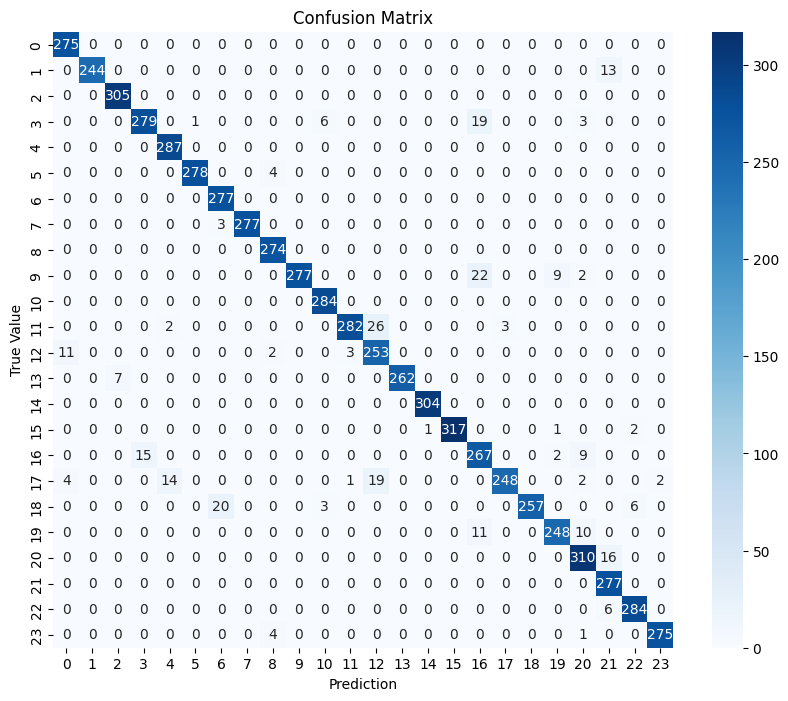

In [20]:
confusionmatrix(true_classes, predicted_classes)

## **Previsioni su nuove immagini**

Per ogni lettera della parola rappresentata nel linguaggio dei segni, si carica l'immagine del segno corrispondente. Le immagini vengono convertite e ristrutturate (`ImageConverter`), così da essere pronte per l'input nel modello di machine learning. 

In [21]:
from Conversione_immagini import ImageConverter

img_path = 'test_images/'
lista = 'abcdefghiklmnopqrstuvwxy'
parola = 'abcdefghiklmnopqrstuvwxy'
img_list = []
for letter in parola:
    Converter = ImageConverter(img_path+letter.upper()+'_test.jpg')
    #Converter.show_image()
    img_list.append(Converter.image_array().reshape(28,28,1))
    

img_array = np.array(img_list)

predicted_classes = predictions(model,img_array)

parola_predetta = ''

for index in range(len(predicted_classes)):

    parola_predetta += lista[predicted_classes[index]]

print('Parola da predire:', parola)
print('Parola predetta',parola_predetta)

lettere_riconosciute1 = []
for index in range(len(parola)):
    if parola[index] == parola_predetta[index]: lettere_riconosciute1.append(lista[index])
print('Lettere riconosciute = ', len(lettere_riconosciute1)/len(parola)*100, '%')
print(lettere_riconosciute1)

img_path = 'test2/'
lista = 'abcdefghiklmnopqrstuvwxy'
parola = 'abcdefghiklmnopqrstuvwxy'
img_list = []
for letter in parola:
    Converter = ImageConverter(img_path+letter+'.jpeg')
    #Converter.show_image()
    img_list.append(Converter.image_array().reshape(28,28,1))
    

img_array = np.array(img_list)

predicted_classes = predictions(model,img_array)

parola_predetta = ''

for index in range(len(predicted_classes)):

    parola_predetta += lista[predicted_classes[index]]

print('Parola da predire:', parola)
print('Parola predetta',parola_predetta)

lettere_riconosciute = []
for index in range(len(parola)):
    if parola[index] == parola_predetta[index]: lettere_riconosciute.append(lista[index])
print('Lettere riconosciute = ', len(lettere_riconosciute)/len(parola)*100, '%')
print(lettere_riconosciute)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Parola da predire: abcdefghiklmnopqrstuvwxy
Parola predetta cqclqfgpgvlopoohlcxcwwxg
Lettere riconosciute =  29.166666666666668 %
['c', 'f', 'g', 'l', 'o', 'w', 'x']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Parola da predire: abcdefghiklmnopqrstuvwxy
Parola predetta kbqqyappikmkpqppkkakwwpa
Lettere riconosciute =  20.833333333333336 %
['b', 'i', 'k', 'p', 'w']


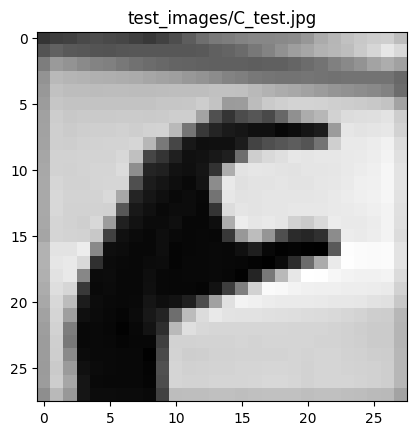

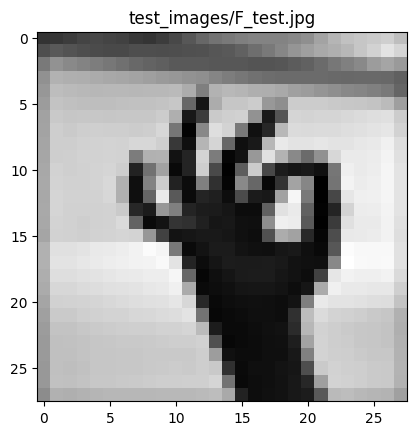

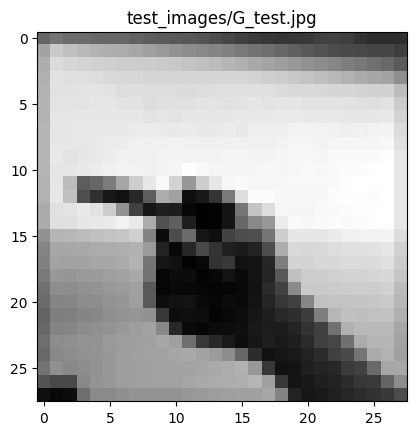

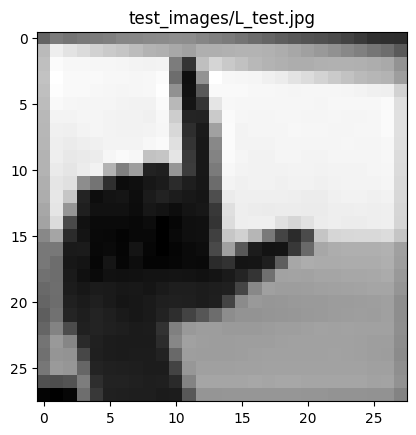

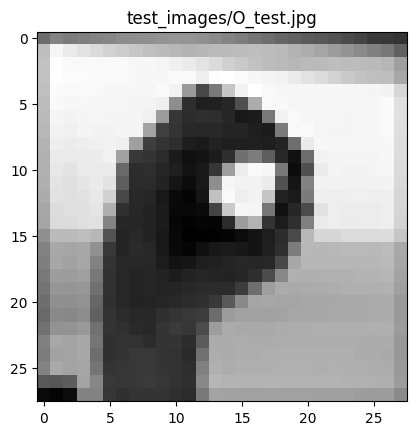

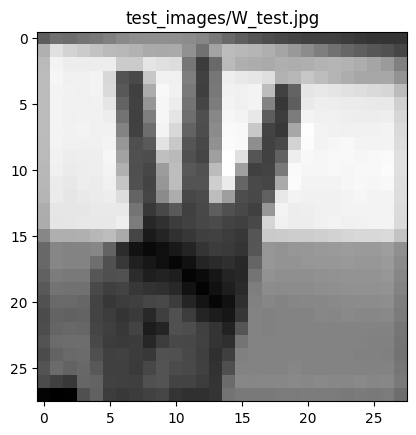

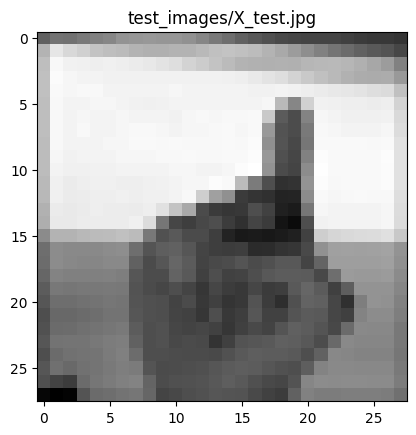

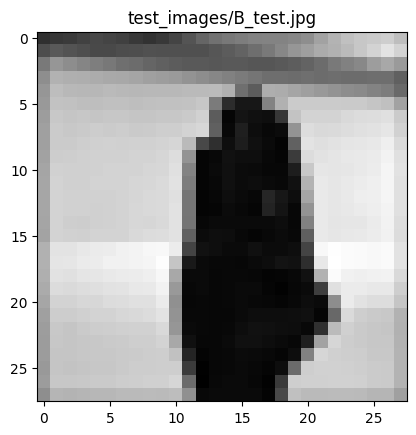

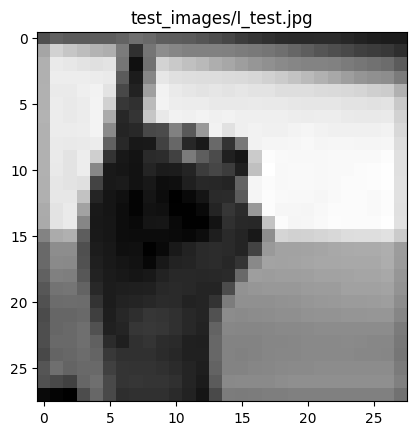

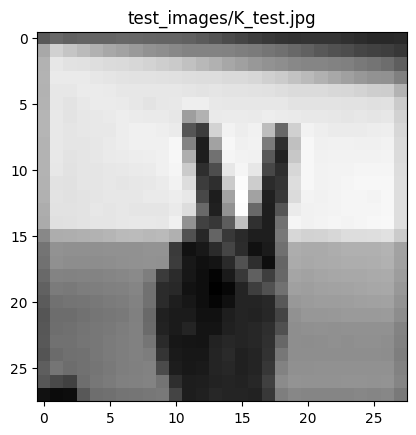

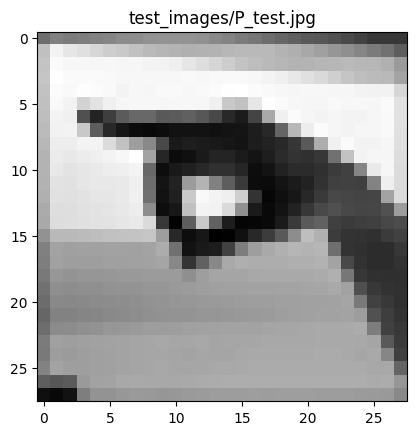

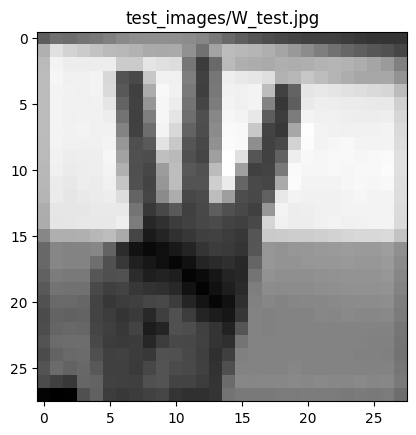

In [22]:
from PIL import Image

for lettera in lettere_riconosciute1:
    
    img_path = 'test_images/' + lettera.upper() +'_test.jpg'

    # Apri l'immagine e converti in scala di grigi
    img = Image.open(img_path).convert('L')

    # Ridimensiona a 28x28
    img = img.resize((28, 28))
    plt.imshow(img, cmap='gray') 
    plt.title(img_path)
    plt.show()

for lettera in lettere_riconosciute:
    
    img_path = 'test_images/' + lettera.upper() +'_test.jpg'

    # Apri l'immagine e converti in scala di grigi
    img = Image.open(img_path).convert('L')

    # Ridimensiona a 28x28
    img = img.resize((28, 28))
    plt.imshow(img, cmap='gray') 
    plt.title(img_path)
    plt.show()

# No data augmentation


In [24]:
train_df = pd.read_csv('sign_mnist_train/sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test/sign_mnist_test.csv')

df=pd.concat(([train_df, test_df]))

label = df['label']
df = df.drop(['label'], axis=1)

X = df.values.astype('float32') / 255
X = X.reshape(-1, 28, 28, 1)

lb = LabelBinarizer()
y = lb.fit_transform(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()

num_k = [32, 64]
k_size = [3, 3]
p_size = [2, 2]
num_n = 128
# Aggiungi i layer convoluzionali e di pooling
for i in range(len(num_k)):
    if i == 0:
        model.add(Conv2D(num_k[i], (k_size[i], k_size[i]), activation='relu', input_shape=(28, 28, 1), kernel_regularizer=l2(0.01)))
    else:
        model.add(Conv2D(num_k[i], (k_size[i], k_size[i]), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D(pool_size=(p_size[i], p_size[i])))

# Aggiungi i layer densi
model.add(Flatten())
model.add(Dense(num_n, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(24, activation='softmax'))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs = 10,
          batch_size = 32,
          #val_split = 0.1
          )

from Conversione_immagini import ImageConverter

img_path = 'test_images/'
lista = 'abcdefghiklmnopqrstuvwxy'
parola = 'abcdefghiklmnopqrstuvwxy'
img_list = []
for letter in parola:
    Converter = ImageConverter(img_path+letter.upper()+'_test.jpg')
    #Converter.show_image()
    img_list.append(Converter.image_array().reshape(28,28,1))
    

img_array = np.array(img_list)

predicted_classes = predictions(model,img_array)

parola_predetta = ''

for index in range(len(predicted_classes)):

    parola_predetta += lista[predicted_classes[index]]

print('Parola da predire:', parola)
print('Parola predetta',parola_predetta)

lettere_riconosciute1 = []
for index in range(len(parola)):
    if parola[index] == parola_predetta[index]: lettere_riconosciute1.append(lista[index])
print('Lettere riconosciute = ', len(lettere_riconosciute1)/len(parola)*100, '%')
print(lettere_riconosciute1)

img_path = 'test2/'
lista = 'abcdefghiklmnopqrstuvwxy'
parola = 'abcdefghiklmnopqrstuvwxy'
img_list = []
for letter in parola:
    Converter = ImageConverter(img_path+letter+'.jpeg')
    #Converter.show_image()
    img_list.append(Converter.image_array().reshape(28,28,1))
    

img_array = np.array(img_list)

predicted_classes = predictions(model,img_array)

parola_predetta = ''

for index in range(len(predicted_classes)):

    parola_predetta += lista[predicted_classes[index]]

print('Parola da predire:', parola)
print('Parola predetta',parola_predetta)

lettere_riconosciute = []
for index in range(len(parola)):
    if parola[index] == parola_predetta[index]: lettere_riconosciute.append(lista[index])
print('Lettere riconosciute = ', len(lettere_riconosciute)/len(parola)*100, '%')
print(lettere_riconosciute)


C:\Users\perri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
866/866 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.4637 - loss: 2.0015
Epoch 2/10
866/866 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9472 - loss: 0.4091
Epoch 3/10
866/866 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9904 - loss: 0.2512
Epoch 4/10
866/866 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9969 - loss: 0.1923
Epoch 5/10
866/866 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9985 - loss: 0.1562
Epoch 6/10
866/866 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9996 - loss: 0.1283
Epoch 7/10
866/866 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9994 - loss: 0.1111
Epoch 8/10
866/866 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9999 - loss: 0.0928
Epoch 9/10
866/866 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9994 - loss: 0.0830
Epoch 10/10
866/866 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9999 - loss: 0.0720
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Parola da predire: abcdefghiklmnopqrstuvwxy
Parola predetta mbcxtfgpgxtnpophlggppwxg
Lettere riconos